In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Load dataset
data = pd.read_csv('customers.csv')
data.head(5)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [3]:
data.columns

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

In [4]:
# Drop ID column as it's not useful for classification
data = data.drop(columns=["ID"])

In [5]:
# Handle missing values
data.fillna({"Work_Experience": 0, "Family_Size": data["Family_Size"].median()}, inplace=True)

In [6]:
# Encode categorical variables
categorical_columns = ["Gender", "Ever_Married", "Graduated", "Profession", "Spending_Score", "Var_1"]
for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col])

In [12]:
data.head(5)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,1,0,22,0,5,1.0,2,4.0,3,3
1,0,1,38,1,2,0.0,0,3.0,3,0
2,0,1,67,1,2,1.0,2,1.0,5,1
3,1,1,67,1,7,0.0,1,2.0,5,1
4,0,1,40,1,3,0.0,1,6.0,5,0


In [7]:
# Encode target variable
label_encoder = LabelEncoder()
data["Segmentation"] = label_encoder.fit_transform(data["Segmentation"])  # A, B, C, D -> 0, 1, 2, 3

In [8]:
# Split features and target
X = data.drop(columns=["Segmentation"])
y = data["Segmentation"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [11]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [25]:
class PeopleClassifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [26]:
# Training Loop
def train_model(model, train_loader, criterion, optimizer, epochs):
  model.train()
  for epoch in range(epochs):
    for inputs,labels in train_loader:
      optimizer.zero_grad()
      outputs=model(inputs)
      loss=criterion(outputs,labels)
      loss.backward()
      optimizer.step()





    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [27]:
# Initialize model
model =PeopleClassifier(input_size=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer =optim.Adam(model.parameters(),lr=0.001)


In [28]:
train_model=train_model(model,train_loader,criterion,optimizer,epochs=100)

Epoch [10/100], Loss: 1.0463
Epoch [20/100], Loss: 1.0601
Epoch [30/100], Loss: 1.4600
Epoch [40/100], Loss: 1.1436
Epoch [50/100], Loss: 1.1395
Epoch [60/100], Loss: 1.0803
Epoch [70/100], Loss: 1.4538
Epoch [80/100], Loss: 0.9991
Epoch [90/100], Loss: 1.2523
Epoch [100/100], Loss: 1.2344


In [29]:
# Evaluation
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())
        actuals.extend(y_batch.numpy())

In [30]:
# Compute metrics
accuracy = accuracy_score(actuals, predictions)
conf_matrix = confusion_matrix(actuals, predictions)
class_report = classification_report(actuals, predictions, target_names=[str(i) for i in label_encoder.classes_])
print("Name:  SAJEN MURALI")
print("Register No:   212223220089")
print(f'Test Accuracy: {accuracy:.2f}%')
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Name:  SAJEN MURALI
Register No:   212223220089
Test Accuracy: 0.47%
Confusion Matrix:
 [[205 119 113 147]
 [115 145 149  81]
 [ 64  76 274  58]
 [127  36  43 387]]
Classification Report:
               precision    recall  f1-score   support

           A       0.40      0.35      0.37       584
           B       0.39      0.30      0.33       490
           C       0.47      0.58      0.52       472
           D       0.58      0.65      0.61       593

    accuracy                           0.47      2139
   macro avg       0.46      0.47      0.46      2139
weighted avg       0.46      0.47      0.46      2139



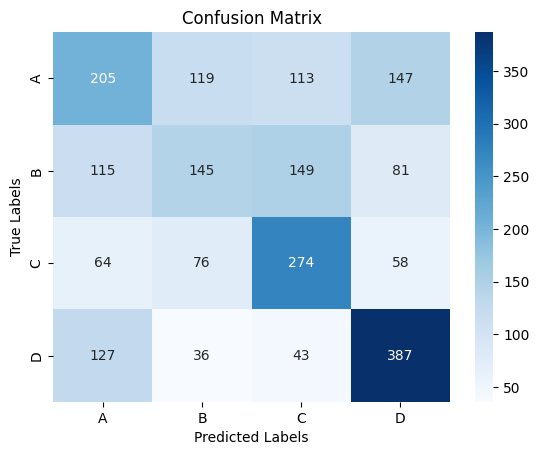

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,fmt='g')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [33]:
# Prediction for a sample input
sample_input = X_test[12].clone().unsqueeze(0).detach().type(torch.float32)
with torch.no_grad():
    output = model(sample_input)
    # Select the prediction for the sample (first element)
    predicted_class_index = torch.argmax(output[0]).item()
    predicted_class_label = label_encoder.inverse_transform([predicted_class_index])[0]
print("Name:   SAJEN MURALI")
print("Register No:  212223220089")
print(f'Predicted class for sample input: {predicted_class_label}')
print(f'Actual class for sample input: {label_encoder.inverse_transform([y_test[12].item()])[0]}')

Name:   SAJEN MURALI
Register No:  212223220089
Predicted class for sample input: D
Actual class for sample input: D
